In [87]:
import libsumo as traci
import time
import random
import numpy as np
import csv
import os
import random, numpy as np
import pandas as pd, matplotlib.pyplot as plt

SEED = 8
random.seed(SEED)
np.random.seed(SEED)
# Imports and configuration
# Use sumo or sumo-gui depending on your preference
SUMO_GUI_BINARY  = "sumo-gui"  # or "sumo-gui"
SUMO_BINARY  = "sumo"  # or "sumo-gui"
SUMO_CFG  = "./sumo_cfg/simulation.sumocfg"  # your .sumocfg file
SUMO_STATE = "./sumo_cfg/simulation_state.xml"  # your initial state file
LOG_DIR= "logs"

# Global timing constants
REDUCE_AVG_WAIT_TIME_W, FAIRNESS_W = 0.7, 0.3 # prioritize reduce wait time
CYCLE_LENGTH_DEFAULT = 90   # s
MAX_CYCLE_LENGTH = 120      # s
MIN_CYCLE_LENGTH = 60      # s
LOST_TIME = 12              # s (amber + all-red total)
GREEN_MIN = 15             # s per direction
MIN_GREEN_SPLIT = GREEN_MIN / (MAX_CYCLE_LENGTH-LOST_TIME)  # minimum green split ratio
END_TIME = 16200

In [88]:
#Intersection metadata
# Define lane groups for metric aggregation
NS_LANES = ["1200728225#1_0", "1200728225#1_1", "1221994726#0_0", "1221994726#0_1"]  # replace with your real lane IDs
EW_LANES = ["1265822568#3_0", "1265822568#3_1", "1265822568#3_2"]

# Your target traffic light ID
TL_ID = "cluster_13075564400_13075589603_411926344"  # replace with your actual traffic light id in SUMO net

## Simulation Section

In [89]:
sumoCmd = [
    SUMO_BINARY,
    "-c", SUMO_CFG,
    "--seed", str(SEED),
]
traci.start(sumoCmd)
print(traci.trafficlight.getControlledLanes(TL_ID))
traci.simulationStep()
signal_state = traci.trafficlight.getRedYellowGreenState(TL_ID)
print(signal_state)
traci.close()

('1265822568#3_0', '1265822568#3_0', '1265822568#3_1', '1265822568#3_2', '1265822568#3_2', '1200728225#1_0', '1200728225#1_1', '1200728225#1_1', '1200728225#1_1', '1221994726#0_0', '1221994726#0_0', '1221994726#0_1')
rrrrrGGggGGG


In [104]:
def apply_plan(tl_id, g_main, g_cross, amber=3, all_red=3):
    """
    Define a 2-phase signal plan (NS and EW) with amber and all-red times.
    """
    amrber_red_phase_duration = amber + all_red
    phases = [
        traci.trafficlight.Phase(g_main, "rrrrrGGggGGG"),   # NS green
        traci.trafficlight.Phase(amrber_red_phase_duration, "rrrrryyyyyyy"),    # NS amber
        traci.trafficlight.Phase(g_cross, "GGGGGrrrrrrr"),  # EW green
        traci.trafficlight.Phase(amrber_red_phase_duration, "yyyyyrrrrrrr"),    # EW amber
    ]

    logic = traci.trafficlight.Logic("custom_logic", 0, 0, phases)
    traci.trafficlight.setCompleteRedYellowGreenDefinition(tl_id, logic)

    # Metrics calculation
def cycle_metrics(ns_lanes, ew_lanes, steps):
    ns_wait_total = ew_wait_total = 0
    ns_veh_total = ew_veh_total = 0
    ns_wait = ew_wait = 0

    for _ in range(steps):
        traci.simulationStep()
        signal_state = traci.trafficlight.getRedYellowGreenState(TL_ID)

         # Split signal state: first 5 (EW), last 7 (NS)
        ew_state = signal_state[:5]
        ns_state = signal_state[5:]

        # Detect if direction is in red
        ew_red = "r" in ew_state
        ns_red = "r" in ns_state
        # Accumulate waiting times and vehicles only when direction is red
        if ns_red:
            ns_wait += 1
            ns_veh_total = sum(traci.lane.getLastStepHaltingNumber(l) for l in ns_lanes)
            ns_wait_total = ns_wait * ns_veh_total
        else:
            ns_wait = 0
        if ew_red:
            ew_wait += 1
            ew_veh_total = sum(traci.lane.getLastStepHaltingNumber(l) for l in ew_lanes)
            ew_wait_total = ew_wait * ew_veh_total
        else:
            ew_wait = 0
    # Compute average per-direction delay (approx.)
    avg_delay_ns = ns_wait_total / max(ns_veh_total, 1)
    avg_delay_ew = ew_wait_total / max(ew_veh_total, 1)
    # Fairness (bounded 0–1)
    fairness = abs(avg_delay_ns - avg_delay_ew) / (avg_delay_ns + avg_delay_ew + 1e-5)
    # Normalized total average delay
    norm_avg_delay = ((ns_wait_total + ew_wait_total) / max(ns_veh_total + ew_veh_total, 1))

    return norm_avg_delay, fairness

def get_green_split(s, C):
    g_main = max(GREEN_MIN, round((C - LOST_TIME) * s))
    g_cross = max(GREEN_MIN, (C - LOST_TIME) - g_main)
    return g_main, g_cross


## Evaluate Section

In [106]:
# Evaluation function
def evaluate(s, C, isReset=True):
    try:    
        # Restore identical starting conditions before evaluating this candidate
        if isReset:
            traci.simulation.loadState(SUMO_STATE)
            time.sleep(0.01)
        g_main, g_cross = get_green_split(s, C)
        apply_plan(TL_ID, g_main, g_cross)
        steps = int(C)
        O1_norm, O2_norm = cycle_metrics(NS_LANES, EW_LANES, steps)

    except traci.exceptions.FatalTraCIError as e:
        print("⚠️ SUMO crashed during evaluation:", e)
        return C, 1  # return a default
    return O1_norm, O2_norm

def score_function(O1, O2):
    score = (REDUCE_AVG_WAIT_TIME_W * O1) + (FAIRNESS_W * O2)
    return score

def evaluate_multi_cycle(x, n_cycles=2):
    """Evaluate the same (s, C) across consecutive cycles without resetting."""
    # Start from base state once
    s, C = float(x[0]), round(float(x[1]))
    traci.simulation.loadState(SUMO_STATE)
    total_O1 = total_O2 = 0
    for _ in range(n_cycles):
        O1, O2 = evaluate(s, C, isReset=False)  # continue simulation
        total_O1 += O1
        total_O2 += O2
    return total_O1 / n_cycles, total_O2 / n_cycles

# x consist of split-Cycle
def evaluate_candidate(x):
    s, C = float(x[0]), round(float(x[1]))  # round C for realism
    O1, O2 = evaluate(s, C)
    return O1, O2

def robust_evaluate(x, n_cycles=3, λ=0.3):
    """Returns (robust_score, mean_O1, mean_O2)"""
    scores = []

    for _ in range(n_cycles):
        O1, O2 = evaluate_multi_cycle(x, n_cycles)
        scores.append(score_function(O1, O2))
    robust_score = np.mean(scores) + λ * np.std(scores)
    return robust_score, O1, O2

In [92]:
from dataclasses import dataclass

@dataclass
class DEResult:
    s: float
    C: float
    O1: float
    O2: float
    score: float
    robust_score: float
    elapsed: float
    gen_history: list

## Evolution Algorithm Section

In [107]:
 # Include previous elite as first individual (temporal continuity)
def init_population(bounds, pop_size, elite_last=None):
    pop = [np.array([random.uniform(*b) for b in bounds]) for _ in range(pop_size)]
    if elite_last is not None:
        pop[0] = np.array([elite_last[0], elite_last[1]])  # temporal continuity
    return pop

# Early stopping check using std
def early_stop_check(gen_history, patience, min_delta, elapsed, time_budget_s):
    if len(gen_history) > patience:
        recent_scores = [h[-1] for h in gen_history[-patience:]]
        score_std = np.std(recent_scores)
        if score_std < min_delta:
            print(f"Early stopping: score std {score_std:.6f} < {min_delta}")
            return True
        
    if elapsed >= time_budget_s:
            return True
    return False

 # --- Select top-K and re-evaluate robustly
def final_robust_selection(pop, scores, K_ratio=0.5):
    K = round(len(pop) * K_ratio)
    ranked = sorted(
        [(pop[i], scores[i], score_function(*scores[i])) for i in range(len(pop))],
        key=lambda x: x[2]
    )
    topK = ranked[:K]
    evaluated = [(x, *robust_evaluate(x)) for x, _, _ in topK]
    winner, best_robust_score, O1_best, O2_best = min(evaluated, key=lambda z: z[1])
    s_best, C_best = winner
    return s_best, C_best, O1_best, O2_best, best_robust_score

def evolve_generation(pop, scores, bounds, F, CR):
    scale = np.array([1.0, 1.0 / (bounds[1][1] - bounds[1][0])])  # scale by range
    pop_size = len(pop)
    new_pop, new_scores = pop.copy(), scores.copy()

    for i in range(pop_size):
        idxs = list(range(pop_size))
        idxs.remove(i)
        r1, r2, r3 = random.sample(idxs, 3)

        # Mutation
        mutant = pop[r1] + F * scale * (pop[r2] - pop[r3])
        mutant = np.clip(mutant, [b[0] for b in bounds], [b[1] for b in bounds])

        # Crossover (ensure at least one mutant gene)
        trial = np.copy(pop[i])
        jrand = random.randrange(len(bounds))
        for j in range(len(bounds)):
            if j == jrand or random.random() < CR:
                trial[j] = mutant[j]

        # Evaluate and selection
        O1_t, O2_t = evaluate_candidate(trial)
        O1_i, O2_i = scores[i]
        score_t = score_function(O1_t, O2_t)
        score_i = score_function(O1_i, O2_i)

        if score_t <= score_i:
            new_pop[i], new_scores[i] = trial, (O1_t, O2_t)

    return new_pop, new_scores

def differential_evolution(
    elite_last=None,
    time_budget_s=120,
    pop_size=12,
    F=0.8,
    CR=0.6,
    patience=5,
    min_delta=1e-3,
):
    """
    Differential Evolution (DE/rand/1/bin)
    for 2 parameters: (s, C)
    Optimizes two objectives (O1, O2) within a strict time budget.

    Returns: DEResult(s_best, C_best, O1_best, O2_best, score_best, best_robust_score, elapsed)
    """

    start = time.perf_counter()
    bounds = [(MIN_GREEN_SPLIT, 1-MIN_GREEN_SPLIT), (MIN_CYCLE_LENGTH, MAX_CYCLE_LENGTH)]  # (s_min, s_max), (C_min, C_max)

    pop = init_population(bounds, pop_size, elite_last)
    scores = [None] * pop_size

    # --- Evaluate initial population
    for i in range(pop_size):
        O1, O2 = evaluate_candidate(pop[i])
        scores[i] = (O1, O2)

    gen = 0
    gen_history = []  # store per-generation bests
    # --- DE optimization loop (time-bounded)
    while time.perf_counter() - start < time_budget_s:
        gen += 1
        pop, scores = evolve_generation(pop, scores, bounds, F, CR)

       # Summary
        best_idx = min(range(pop_size),
                       key=lambda k: score_function(scores[k][0], scores[k][1]))
        best = pop[best_idx]
        s_best, C_best = best
        O1_best, O2_best = scores[best_idx]
        score_best = score_function(O1_best, O2_best)
        elapsed = time.perf_counter() - start

        # print(f"gen {gen:02d} | t={elapsed:4.1f}s | "
        #       f"s={s_best:.3f} C={C_best:.1f} "
        #       f"O1={O1_best:.3f} O2={O2_best:.3f} score={score_best:.3f}")

        gen_history.append((elapsed, s_best, C_best, O1_best, O2_best, score_best))

        if early_stop_check(gen_history, patience, min_delta, elapsed, time_budget_s):
            break

    # --- Final best with robust evaluation
    s_best, C_best, O1_best, O2_best, best_robust_score = final_robust_selection(pop, scores)
    elapsed = time.perf_counter() - start

    return DEResult(s_best, C_best, O1_best, O2_best, score_best, best_robust_score, elapsed, gen_history)


In [108]:
import csv, os
from datetime import datetime

def log_cycle_result(
    cycle,
    s,
    C,
    O1,
    O2,
    score_best,
    robust_score,
    elapsed_s,
    suffix="",
    out_dir=LOG_DIR,
    prefix="DE_cycle",
):
    """
    Append one cycle results to a CSV log file
    """
    # --- Create output folder
    os.makedirs(out_dir, exist_ok=True)

    # Main summary file (aggregated cycle-level results)
    summary_file = os.path.join(out_dir, f"{prefix}_summary_{suffix}.csv")
    write_header = not os.path.exists(summary_file)

    with open(summary_file, "a", newline="") as f:
        writer = csv.writer(f)
        if write_header:
            writer.writerow([
                "cycle", "s", "C", "O1", "O2",
                "score_best", "robust_score", "elapsed_s"
            ])
        writer.writerow([
            cycle, round(s, 3), round(C, 1), round(O1, 3), round(O2, 3),
            round(score_best, 4), round(robust_score, 4), round(elapsed_s, 2)
        ])

    return summary_file

In [109]:
def seed_de_simulation():
    # Start SUMO
    sumoCmd = [
        SUMO_BINARY,
        "-c", SUMO_CFG,
        "--seed", str(SEED),
    ]
    log_suffix = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_file = ""

    elite = [0.5, CYCLE_LENGTH_DEFAULT]  # initial elite

    traci.start(sumoCmd)
    for cycle in range(300):  # min 50s per cycle ~ 325 cycle for 16200s
        time_pased = traci.simulation.getTime()
        print(f"Time passed at cycle {cycle+1}: {time_pased}s.")
        if time_pased >= END_TIME:
            print(f"❌ No more vehicles at cycle {cycle+1}, stopping early.")
            break
        print(f"\n=== Cycle {cycle+1} (t={time_pased:.1f}s) ===")
        #  Save the current live SUMO state once
        traci.simulation.saveState(SUMO_STATE)

        #  Run DE using that snapshot as baseline
        result = differential_evolution(elite_last=elite)
        s, C, O1, O2, score_best, robust_score, elapsed_s, gen_history = (
            result.s, result.C, result.O1, result.O2,
            result.score, result.robust_score, result.elapsed, result.gen_history
        )
        elite = (s, C)

        #  Restore pre-optimization state before applying best plan
        traci.simulation.loadState(SUMO_STATE)

        #  Apply only the *best plan* to the live SUMO world
        g_main, g_cross = get_green_split(s, C)
        apply_plan(TL_ID, g_main, g_cross)

        for _ in range(int(C)):
            traci.simulationStep()
            
        #  Log and write results
        print(
            f"Chosen split={s:.2f}, C={C:.1f}, "
            f"O1={O1:.3f}, O2={O2:.3f}, score={score_best:.3f}, time={elapsed_s:.2f}s"
        )
        # Save logs
        log_file = log_cycle_result(
            cycle + 1, s, C, O1, O2, score_best, robust_score, elapsed_s,
            suffix=log_suffix, out_dir="logs", prefix="traffic_DE"
        )

    traci.close()    
    print(f"\n✅ Simulation completed — results saved to {log_file}")


# Run the function
# seed_de_simulation()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def visualize_pow_results(log_dir, suffix="", prefix="traffic_DE"):
    """
    Visualize core PoW evidence from your DE summary CSV.
    Expects: CSV created by log_cycle_result()
    Plots:
        1. Cycle length evolution (adaptivity)
        2. Objective trends (O1, O2)
        3. Score trend (convergence)
        4. Optimization runtime per cycle
        5. Baseline vs. EA improvement summary (optional if baseline exists)
    """
    # --- Load summary CSV
    summary_file = os.path.join(log_dir, f"{prefix}_summary_{suffix}.csv")
    if not os.path.exists(summary_file):
        print(f"❌ Summary file not found: {summary_file}")
        return

    df = pd.read_csv(summary_file)
    print(f"Loaded {len(df)} cycles from {summary_file}")

    # --- 1. Cycle length evolution
    plt.figure(figsize=(7,4))
    plt.plot(df["cycle"], df["C"], marker='o')
    plt.xlabel("Cycle #")
    plt.ylabel("Cycle length (s)")
    plt.title("Adaptive cycle length over time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- 2. Objective trends
    plt.figure(figsize=(7,4))
    plt.plot(df["cycle"], df["O1"], label="Avg delay (O1)")
    plt.plot(df["cycle"], df["O2"], label="Fairness (O2)")
    plt.xlabel("Cycle #")
    plt.ylabel("Objective value")
    plt.title("Objective trends over cycles")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- 3. Score trend
    plt.figure(figsize=(7,4))
    plt.plot(df["cycle"], df["score_best"], label="Score (per cycle)", color='orange')
    plt.plot(df["cycle"], df["robust_score"], label="Robust score (multi-cycle)", color='green')
    plt.xlabel("Cycle #")
    plt.ylabel("Score")
    plt.title("Optimization score per cycle")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- 4. Runtime feasibility
    plt.figure(figsize=(7,4))
    plt.plot(df["cycle"], df["elapsed_s"], label="Runtime per optimization", color='red')
    plt.axhline(y=15, color='gray', linestyle='--', label="15s real-time bound")
    plt.xlabel("Cycle #")
    plt.ylabel("Computation time (s)")
    plt.title("Optimization runtime per cycle")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- 5. Summary statistics
    print("\n=== Summary statistics ===")
    print(df[["C","O1","O2","score_best","elapsed_s"]].describe().round(3))
    avg_runtime = df["elapsed_s"].mean()
    print(f"\n✅  Average runtime per DE optimization: {avg_runtime:.2f}s")
    print("✅ Visualization complete — core PoW evidence generated.")


Loaded 327 cycles from logs/traffic_DE_summary_20251105_203454.csv


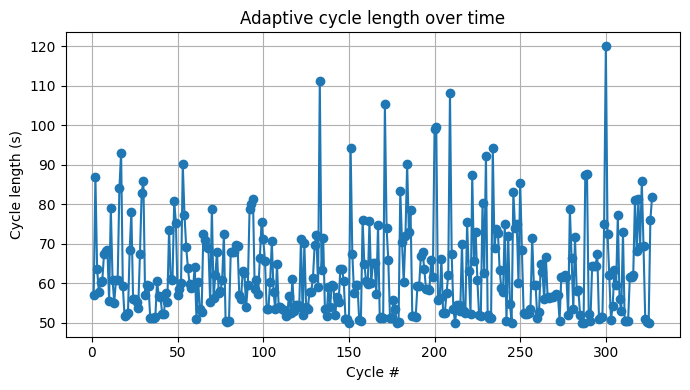

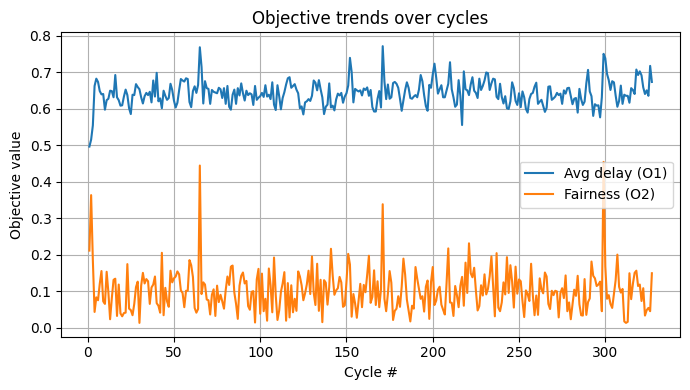

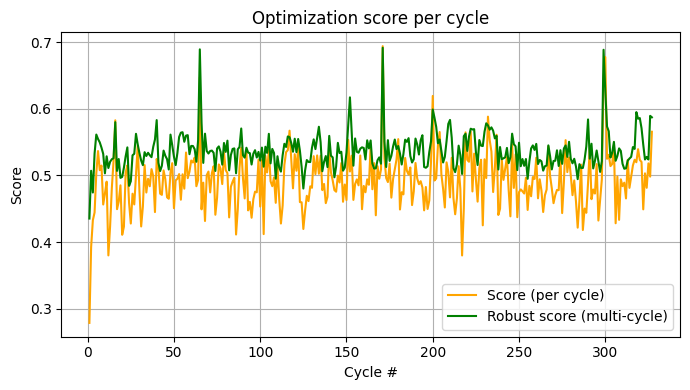

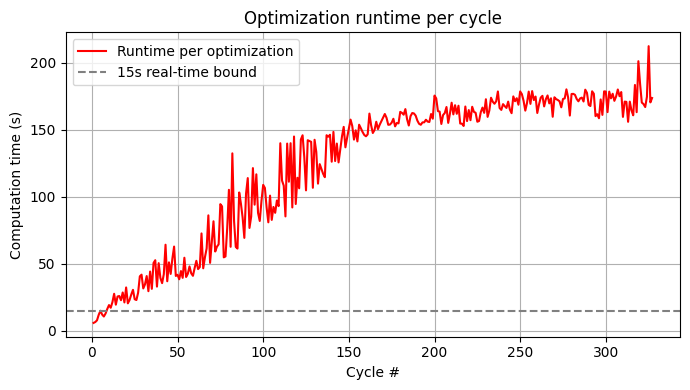


=== Summary statistics ===
             C       O1       O2  score_best  elapsed_s
count  327.000  327.000  327.000     327.000    327.000
mean    62.811    0.642    0.102       0.492    124.108
std     11.828    0.033    0.058       0.042     54.300
min     50.000    0.496    0.013       0.278      5.820
25%     53.400    0.623    0.060       0.466     81.845
50%     59.600    0.640    0.097       0.493    152.930
75%     68.500    0.661    0.132       0.517    167.185
max    120.000    0.771    0.454       0.694    212.540

✅  Average runtime per DE optimization: 124.11s
✅ Visualization complete — core PoW evidence generated.


In [ ]:
visualize_pow_results(log_dir=LOG_DIR, suffix="20251105_203454")

In [ ]:
def baseline_simulation(fixed_s=0.5, fixed_C=90, total_cycles=300):
    """
    Baseline simulation using a fixed signal plan (no optimization).
    Uses identical SUMO setup and logging as the DE version
    for direct comparison.
    """
    sumoCmd = [
        SUMO_BINARY,
        "-c", SUMO_CFG,
        "--seed", str(SEED),
    ]
    log_suffix = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_file = ""

    print(f"Running baseline simulation: s={fixed_s}, C={fixed_C}s for {total_cycles} cycles")

    traci.start(sumoCmd) 
    for cycle in range(total_cycles):
        time_pased = traci.simulation.getTime()
        print(f"Time passed at cycle {cycle+1}: {time_pased}s.")
        if time_pased >= END_TIME:
            print(f"❌ No more vehicles at cycle {cycle+1}, stopping early.")
            break
        print(f"\n=== Cycle {cycle+1} (t={time_pased:.1f}s) ===")
        
        # Apply fixed plan
        g_main, g_cross = get_green_split(fixed_s, fixed_C)
        apply_plan(TL_ID, g_main, g_cross)

        # Evaluate performance under fixed plan
        O1, O2 = cycle_metrics(NS_LANES, EW_LANES, int(fixed_C))
        score_best = score_function(O1, O2)
        robust_score = 0  # no multi-cycle robust re-evaluation
        elapsed_s = 0.0  # not optimized, so no runtime cost

        # Save current state (optional, just for consistency)
        traci.simulation.saveState(SUMO_STATE)

        # Log
        print(
            f"Fixed split={fixed_s:.2f}, C={fixed_C:.1f}, "
            f"O1={O1:.3f}, O2={O2:.3f}, score={score_best:.3f}"
        )

        # Write results
        log_file = log_cycle_result(
            cycle + 1,
            fixed_s,
            fixed_C,
            O1,
            O2,
            score_best,
            robust_score,
            elapsed_s,
            suffix=log_suffix,
            out_dir="logs",
            prefix="traffic_baseline",
        )
    traci.close()   
    print(f"\n✅ Baseline completed — results saved to {log_file}")

baseline_simulation()


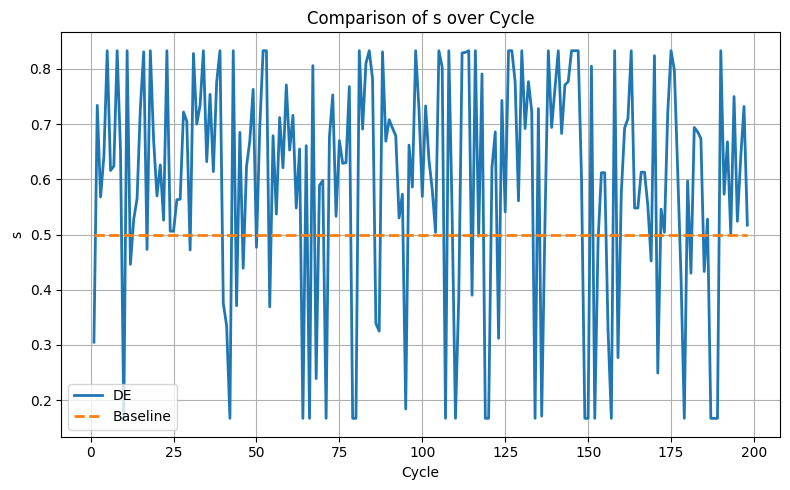

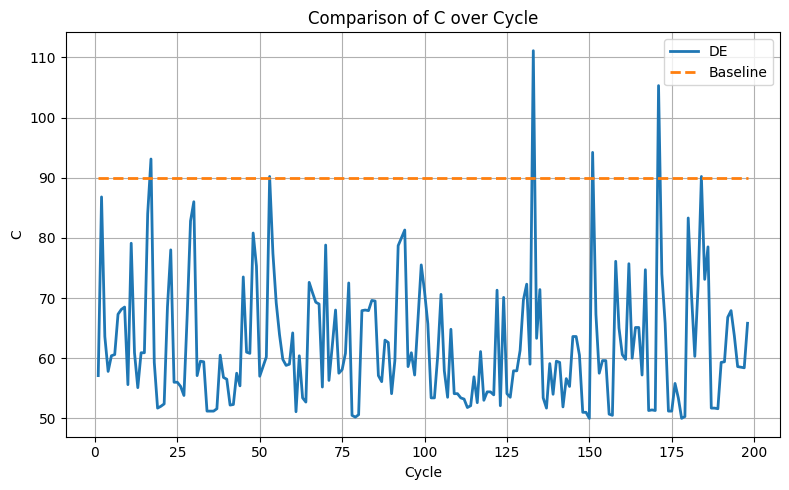

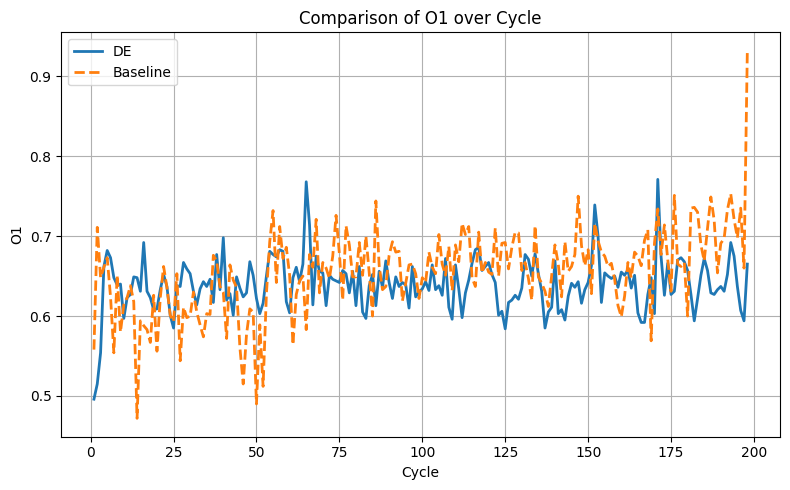

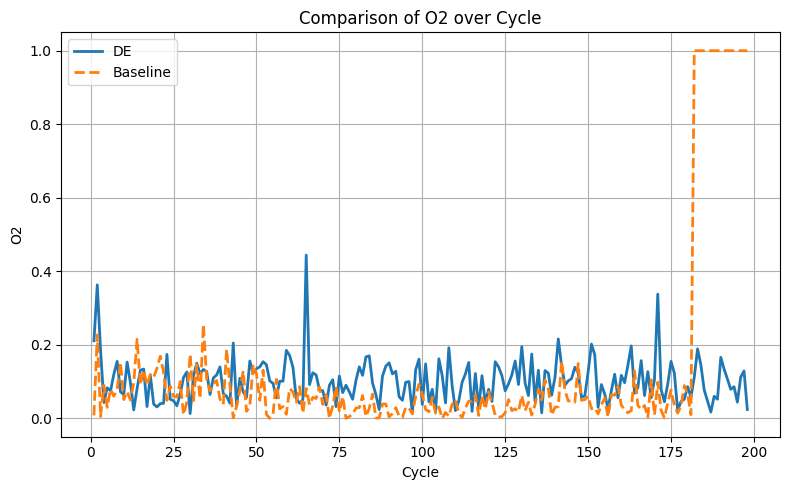

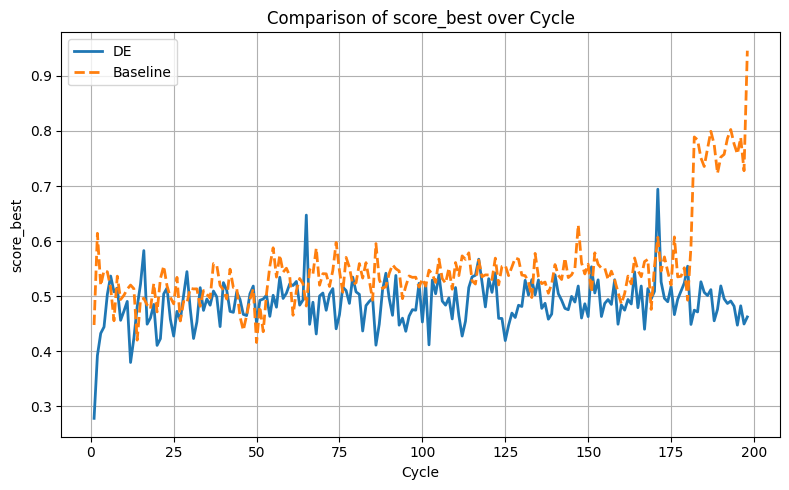

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_logs_by_time(log_dir=LOG_DIR, baseline_prefix='traffic_baseline', de_prefix ='traffic_DE', baseline_suffix = "", de_suffix = ""):
    """
    Compare DE and baseline log files by plotting s, C, O1, and O2 
    against time lapse (cycle × C).

    Parameters:
        de_path (str): Path to DE log CSV file
        baseline_path (str): Path to baseline log CSV file
    """

    de_path = os.path.join(log_dir, f"{de_prefix}_summary_{de_suffix}.csv")
    baseline_path = os.path.join(log_dir, f"{baseline_prefix}_summary_{baseline_suffix}.csv")
    if not os.path.exists(de_path):
        print(f"❌ Summary file not found: {de_path}")
        return
    if not os.path.exists(baseline_path):
        print(f"❌ Summary file not found: {baseline_path}")
        return
    # Load CSVs
    de = pd.read_csv(de_path)
    baseline = pd.read_csv(baseline_path)

     # Ensure same length / alignment
    min_len = min(len(de), len(baseline))
    de = de.head(min_len)
    baseline = baseline.head(min_len)

     # Variables to compare
    vars_to_plot = ["s", "C", "O1", "O2", "score_best"]

    # Plot each variable
    for v in vars_to_plot:
        plt.figure(figsize=(8, 5))
        plt.plot(de["cycle"], de[v], label="DE", linewidth=2)
        plt.plot(baseline["cycle"], baseline[v], label="Baseline", linestyle="--", linewidth=2)
        plt.xlabel("Cycle")
        plt.ylabel(v)
        plt.title(f"Comparison of {v} over Cycle")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

compare_logs_by_time(de_suffix='20251105_203454', baseline_suffix='20251106_084755')

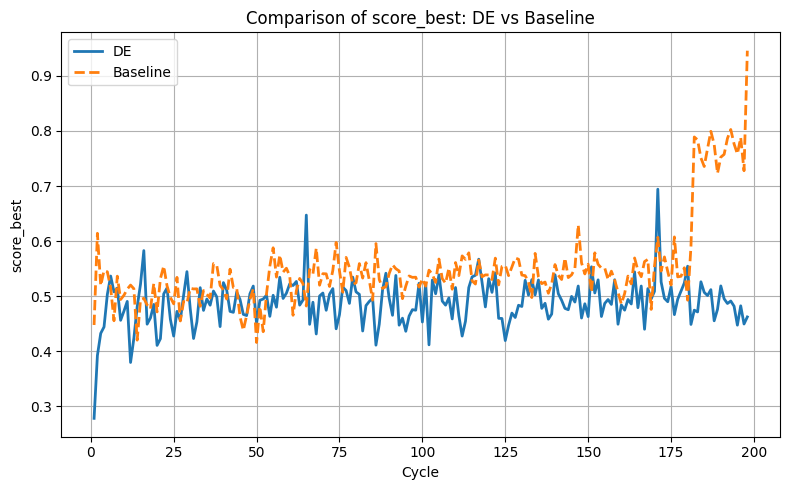

Average DE score_best: 0.4888
Average Baseline score_best: 0.5512
Δ Improvement: -0.0624 (-11.33% change)
❌ DE performs worse than Baseline.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_score_best(log_dir=LOG_DIR, baseline_prefix='traffic_baseline', de_prefix ='traffic_DE', baseline_suffix = "", de_suffix = ""):
    """
    Compare DE vs Baseline based on score_best over cycles.
    Shows a line plot and prints basic improvement summary.
    
    Parameters:
        de_path (str): Path to DE log CSV file
        baseline_path (str): Path to baseline log CSV file
    """
    de_path = os.path.join(log_dir, f"{de_prefix}_summary_{de_suffix}.csv")
    baseline_path = os.path.join(log_dir, f"{baseline_prefix}_summary_{baseline_suffix}.csv")
    if not os.path.exists(de_path):
        print(f"❌ Summary file not found: {de_path}")
        return
    if not os.path.exists(baseline_path):
        print(f"❌ Summary file not found: {baseline_path}")
        return
    # Load CSVs
    de = pd.read_csv(de_path)
    baseline = pd.read_csv(baseline_path)

    # Load the CSVs
    de = pd.read_csv(de_path)
    baseline = pd.read_csv(baseline_path)

    # Ensure same length / alignment
    min_len = min(len(de), len(baseline))
    de = de.head(min_len)
    baseline = baseline.head(min_len)

    # Plot comparison
    plt.figure(figsize=(8, 5))
    plt.plot(de["cycle"], de["score_best"], label="DE", linewidth=2)
    plt.plot(baseline["cycle"], baseline["score_best"], label="Baseline", linestyle="--", linewidth=2)
    plt.xlabel("Cycle")
    plt.ylabel("score_best")
    plt.title("Comparison of score_best: DE vs Baseline")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print summary stats
    mean_de = de["score_best"].mean()
    mean_base = baseline["score_best"].mean()
    diff = mean_de - mean_base

    print(f"Average DE score_best: {mean_de:.4f}")
    print(f"Average Baseline score_best: {mean_base:.4f}")
    print(f"Δ Improvement: {diff:+.4f} ({(diff / mean_base) * 100:.2f}% change)")

    if diff > 0:
        print("✅ DE improves over Baseline.")
    elif diff < 0:
        print("❌ DE performs worse than Baseline.")
    else:
        print("⚖️ DE and Baseline perform equally.")

compare_score_best(de_suffix='20251105_203454', baseline_suffix='20251106_084755')